In [7]:
# For numerical calculations
import numpy as np
import pandas as pd
import scipy as sp
import math
import matplotlib.animation as animation
from scipy.integrate import odeint
from numpy.random import randint
from numpy import arange
from pylab import *
from scipy.integrate import odeint
import scipy.optimize 
from scipy.optimize import leastsq
from math import exp
from collections import OrderedDict
from sklearn.linear_model import LinearRegression
pd.options.mode.chained_assignment = None
import git

# Find home directory for repo
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

# Import plotting features
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("ticks")
sns.set_palette("colorblind", color_codes=True)
sns.set_context("paper")

# Magic command to plot inline
%matplotlib inline

#To graph in SVG (high def)
%config InlineBackend.figure_format="svg"

In [8]:
# Import table with data
df_data =  pd.read_csv(f'{homedir}/SUP05/data/raw/growth/20231020_growth.csv') 
#See data
df_data.head(200)

,Time_h,Replicate,Cells_ml_avg,Cells_ml_stdev,thiosulfate_uM
0,0,a,10000.0,0.0,955.156047
1,0,b,10000.0,0.0,956.993479
2,0,c,10000.0,0.0,952.343704
3,70,a,37300.0,30300.0,770.588000
4,70,b,22400.0,34800.0,788.696000
5,70,c,29800.0,30100.0,772.934000
6,166,a,693000.0,90300.0,650.126000
7,166,b,507000.0,137000.0,688.332000
8,166,c,604000.0,76200.0,645.740000
9,178,a,1100000.0,348000.0,530.548000


In [9]:
# Calculate the mean and standard deviation                           
df_growth = df_data.groupby(['Time_h']).agg(
                    {'Cells_ml_avg':['mean'],
                     'thiosulfate_uM':['mean','std']})
#Change non existing values to 0
#df_growth = df_growth.fillna(0)
#Rename columns after agg
df_growth.columns = ["_".join(x) for x in df_growth.columns.ravel()]
#Drop first level of table after agg
df_growth = df_growth.reset_index()
df_growth

,Time_h,Cells_ml_avg_mean,thiosulfate_uM_mean,thiosulfate_uM_std
0,0,1.000000e+04,954.831077,2.341860
1,70,2.983333e+04,777.406000,9.847538
2,166,6.013333e+05,661.399333,23.427242
3,178,9.976667e+05,541.598000,11.565548
4,190,1.673333e+06,313.684000,23.630648
5,286,2.620000e+07,171.307333,19.137711


## Plots of cells and concentrations vs. time

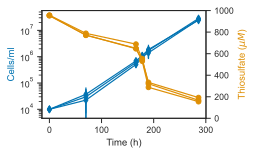

In [10]:
#Make a plot of cells and concentrations vs. time 
# Group by replicate
df_treatments = df_data.groupby(['Replicate'])
# Define colors
colors = sns.color_palette('colorblind', n_colors=6)
# Define markers
markers = ['d', 'o','.','s','x','X']

# Define fig and axes
fig = plt.figure(figsize=(2.95, 1.95), dpi=192)
ax = fig.add_subplot(111)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

for i, (group, data) in enumerate(df_treatments):
    ax.errorbar(data.Time_h, data.Cells_ml_avg, yerr=data.Cells_ml_stdev, color=colors[0], marker=markers[0], label = group)
    ax2.errorbar(data.Time_h, data.thiosulfate_uM, color=colors[1], marker=markers[1], label = group)
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Cells/ml', color = colors[0])
    ax2.set_ylabel('Thiosulfate ($\mu M$)', color=colors[1])
    ax.set_yscale('log')
    ax2.set_ylim([0, 1000])

#Save figure
fig.savefig(f'{homedir}/sup05/figures/growth.pdf', bbox_inches='tight')

In [14]:
#Get ratios of cells/ml between timepoints for each replicate
df_data['ratio_cells'] = df_data['Cells_ml_avg'].div(df_data.groupby(['Replicate'])['Cells_ml_avg'].shift(1)).fillna(0) 
#Get differences between timepoints for each replicate
df_data['diff_time_h'] = df_data.groupby(['Replicate'])['Time_h'].diff().fillna(0)
#Get differences between cells/ml between timepoints for each replicate
df_data['diff_cells'] = df_data.groupby(['Replicate'])['Cells_ml_avg'].diff().fillna(0)
#Get differences between thiosulfate concentrations between timepoints for each replicate
df_data['diff_thiosulfate_uM'] = abs(df_data.groupby(['Replicate'])['thiosulfate_uM'].diff().fillna(0))
#Calculate growth rates in day^-1
df_data['growth_rate'] = np.log(df_data['ratio_cells'])*24/df_data['diff_time_h']
#Get maximum growth rates per replicate
df_data['max_growth_rate']= df_data.groupby(['Replicate'])['growth_rate'].transform(max)
#Determine cell-specific thiosulfate oxidation rate (csTOR)
df_data['csTOR'] = df_data['max_growth_rate']*df_data['diff_thiosulfate_uM']*10**6/df_data['diff_cells']
#See dataframe
df_data

/Users/dosorior/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Time_h,Replicate,Cells_ml_avg,Cells_ml_stdev,thiosulfate_uM,ratio_cells,diff_time_h,diff_cells,diff_thiosulfate_uM,growth_rate,max_growth_rate,csTOR
0,0,a,10000.0,0.0,955.156047,0.000000,0.0,0.0,0.000000,-inf,1.071923,NaN
1,0,b,10000.0,0.0,956.993479,0.000000,0.0,0.0,0.000000,-inf,1.302524,NaN
2,0,c,10000.0,0.0,952.343704,0.000000,0.0,0.0,0.000000,-inf,0.990281,NaN
3,70,a,37300.0,30300.0,770.588000,3.730000,70.0,27300.0,184.568047,0.451340,1.071923,7246.987937
4,70,b,22400.0,34800.0,788.696000,2.240000,70.0,12400.0,168.297479,0.276506,1.302524,17678.351797
5,70,c,29800.0,30100.0,772.934000,2.980000,70.0,19800.0,179.409704,0.374374,0.990281,8973.028408
6,166,a,693000.0,90300.0,650.126000,18.579088,96.0,655700.0,120.462000,0.730509,1.071923,196.928491
7,166,b,507000.0,137000.0,688.332000,22.633929,96.0,484600.0,100.364000,0.779863,1.302524,269.761767
8,166,c,604000.0,76200.0,645.740000,20.268456,96.0,574200.0,127.194000,0.752266,0.990281,219.362173
9,178,a,1100000.0,348000.0,530.548000,1.587302,12.0,407000.0,119.578000,0.924071,1.071923,314.934722


In [15]:
# Calculate the mean and standard deviation for the timepoint with the max growth rate
df_data_190 = df_data[(df_data.Time_h == 190)]
df_stats = df_data_190.agg(
                    {'max_growth_rate':['mean','std'],
                     'csTOR':['mean','std']})
df_stats

,max_growth_rate,csTOR
mean,1.121576,397.043283
std,0.161935,82.211763
